Train a GPR model with "RDkit featurization" and check performance by r2_score, MSE, MAE

In [1]:
# Train a GPR model with RDkit featurization
import deepchem as dc
import pandas as pd
import numpy as np
import rdkit
import sklearn

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Error: Unable to import pysam. Please make sure it is installed.
Error: Unable to import pysam. Please make sure it is installed.
Error: Unable to import pysam. Please make sure it is installed.

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
#load the dataset (polymer smiles and their energy of atomization)

print("loading the data...")
loader = dc.data.CSVLoader(["Eat"], feature_field="smiles", featurizer=dc.feat.RDKitDescriptors())
Data = loader.create_dataset('../csv_files/Polymers_Eat.csv')

loading the data...


In [3]:
print("before:  ",Data)
#some RDKit descriptors return nan, make these 0
X = np.nan_to_num(Data.X, copy=True, nan=0, neginf=0, posinf= 0)

#now run pca to reduce the amount of features (keep 99%)
from sklearn.decomposition import PCA

#get the principal components that retain 99 % of the info
pca = PCA(0.99)
X_PCA = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
print(X_PCA.shape)

#add data to dataset
Dataset = dc.data.DiskDataset.from_numpy(X=X_PCA, y=Data.y, w=Data.w, ids=Data.ids, tasks = ["Ei"])
print("after:  ",Dataset)

before:   <DiskDataset X.shape: (390, 210), y.shape: (390, 1), w.shape: (390, 1), ids: ['[*]CC([*])C' '[*]CC([*])F' '[*]CC([*])(F)F' ...
 '[*]C(F)(F)C(=O)C(F)(F)C(C=C1)=CC=C1[*]' '[*]C(F)(F)OC(F)(F)O[*]'
 '[*]N(C(=O)C1=C2)C(=O)C1=CC=C2C(=O)C(=CC=C3C4(=O))C=C3C(=O)N4C(C)COCCOCCOC(C)COCC(C)[*]'], task_names: ['Eat']>
[0.94601902 0.02669832 0.00713998 0.00553149 0.00475171]
(390, 5)
after:   <DiskDataset X.shape: (390, 5), y.shape: (390, 1), w.shape: (390, 1), ids: ['[*]CC([*])C' '[*]CC([*])F' '[*]CC([*])(F)F' ...
 '[*]C(F)(F)C(=O)C(F)(F)C(C=C1)=CC=C1[*]' '[*]C(F)(F)OC(F)(F)O[*]'
 '[*]N(C(=O)C1=C2)C(=O)C1=CC=C2C(=O)C(=CC=C3C4(=O))C=C3C(=O)N4C(C)COCCOCCOC(C)COCC(C)[*]'], task_names: ['Ei']>


In [4]:
#split the dataset using the random splitter
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(Dataset)
print("Data is splitted into: train, valid, test")

Data is splitted into: train, valid, test


In [177]:
print(test_dataset.y)

[[-6.08]
 [-6.51]
 [-5.98]
 [-5.92]
 [-5.86]
 [-5.15]
 [-6.42]
 [-6.4 ]
 [-5.49]
 [-6.07]
 [-5.86]
 [-5.69]
 [-6.22]
 [-5.52]
 [-6.14]
 [-5.82]
 [-6.26]
 [-6.  ]
 [-6.24]
 [-6.11]
 [-5.99]
 [-6.  ]
 [-6.02]
 [-6.26]
 [-5.66]
 [-5.94]
 [-6.21]
 [-6.12]
 [-5.31]
 [-5.08]
 [-5.92]
 [-5.22]
 [-5.66]
 [-6.14]
 [-6.34]
 [-6.12]
 [-5.96]
 [-6.02]
 [-5.25]
 [-5.79]
 [-5.52]
 [-5.8 ]
 [-5.69]
 [-6.05]
 [-6.19]
 [-6.27]
 [-5.74]
 [-5.61]
 [-6.3 ]
 [-6.14]
 [-5.84]
 [-6.27]
 [-5.99]
 [-5.2 ]
 [-6.34]
 [-5.12]
 [-6.  ]
 [-6.34]
 [-6.47]
 [-6.18]
 [-5.21]
 [-5.41]
 [-5.95]
 [-5.29]
 [-5.25]
 [-6.27]
 [-5.88]
 [-5.9 ]
 [-6.17]
 [-5.8 ]
 [-6.18]
 [-5.78]
 [-5.27]
 [-5.56]
 [-6.21]
 [-6.23]
 [-6.09]
 [-6.05]]


In [6]:
# create the GPR model & fit the model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF()
model = dc.models.SklearnModel(GaussianProcessRegressor( kernel = kernel, n_restarts_optimizer=20))

print("fitting model...")
model.fit(train_dataset)
print("model is fitted")


fitting model...
model is fitted


In [7]:
#calculate r2 score
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('Training set score:', model.evaluate(train_dataset, metric))
test_score= model.evaluate(test_dataset, metric)
print('Test set score:',test_score )

Training set score: {'pearson_r2_score': 0.999999999999996}
Test set score: {'pearson_r2_score': 0.02630289929452448}


In [8]:
#calculate MSE score
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
print('Training set score:', model.evaluate(train_dataset, metric))
print('Test set score:', model.evaluate(test_dataset, metric))

Training set score: {'mean_squared_error': 5.529848790200953e-16}
Test set score: {'mean_squared_error': 2.38405836861882}


In [9]:
#calculate MAE score
metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)
print('Training set score:', model.evaluate(train_dataset, metric))
print('Test set score:', model.evaluate(test_dataset, metric))

Training set score: {'mean_absolute_error': 4.526007713911129e-09}
Test set score: {'mean_absolute_error': 0.631572810503212}


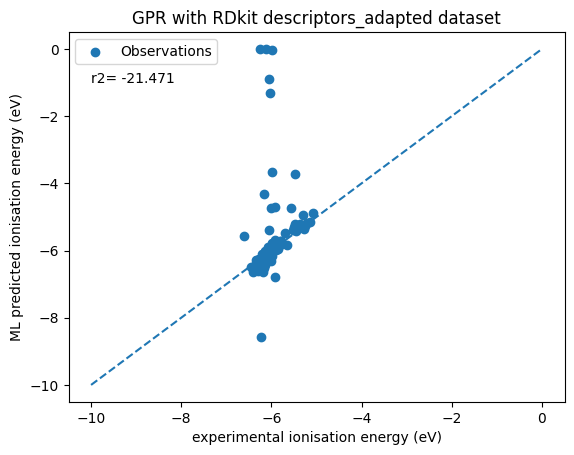

In [10]:
#plot the data
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

#predict the r2_score and convert to string
predicted = model.predict(test_dataset)
score =r2_score(test_dataset.y, predicted)
text = "r2= "+ str(round(score,3))

x=[-10,0]
y=[-10,0]
#text = "R2= "+ str(round(test_score))
plt.plot(x, y, linestyle="dashed")
plt.scatter(test_dataset.y, predicted, label="Observations")
plt.legend()
plt.xlabel("experimental ionisation energy (eV)")
plt.ylabel("ML predicted ionisation energy (eV)")
plt.title("GPR with RDkit descriptors_adapted dataset")
plt.text(-10,-1,text)
plt.show()
